## Kalman Filter & 3D Experiment

In [1]:
# Import aller benötigten Module
%matplotlib notebook
# Eigene Module
from DataGenerationRadar3D import *
from DBScan import *
from Widgets3D import *
# Externe Module
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from collections import deque
from ipywidgets import interact, interactive, interactive_output, fixed, interact_manual
import ipywidgets as widgets

Um ein besseres Verständis für das Kalman Filter zu erlangen, haben wir uns zunächst mit der Theorie dahinter beschäftigt. Im Zuge dieses Prozesses sind wir auf den $\alpha$-$\beta$-Filter gestoßen, welcher mit dem Kalman Filter verwandt ist. Wir haben diesen zu Übungszwecken implementiert und dazu verwendet das Körpergewicht vorherzusagen.
In diesem Fall treffen wir die Annahme..

In [20]:
class abFilter:
    def __init__(self, x0, dx, a, b, dt):
        self.x_est = x0
        self.dx = dx
        self.a = a
        self.b = b
        self.dt = dt
    
    def step(self, values):
        results = []
        predictions = []
        for z in values:
            x_pred = self.x_est + (self.dx*self.dt)
            predictions.append(x_pred)
            residual = z - x_pred
            self.dx = self.dx + self.b * (residual)/self.dt
            print(self.dx)
            self.x_est = x_pred + self.a * residual
            results.append(self.x_est)
        return np.array(results), np.array(predictions)

0.16666666666667235
0.6822222222222232
0.033629629629630564
0.48510617283949947
0.2756260082304568
0.1414166035665364
0.26012177265660424
0.13418932518822724
0.12769012940872046
0.17329703149110848
0.27600843799666175
-0.06691262473222925
0.5071940333310331
0.3320406743356499


<IPython.core.display.Javascript object>


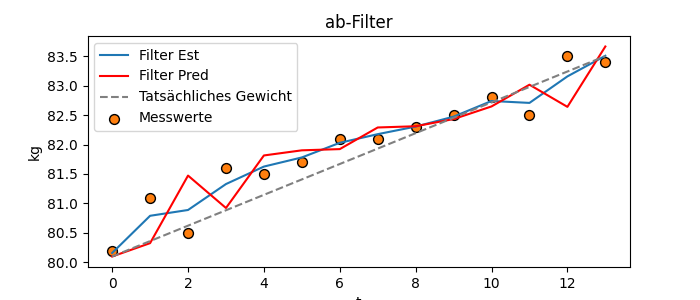

In [21]:
# Daten: Körpergewichte über 14 Wochen verteilt gemessen
echtes_gew = [80.2, 81.1, 80.5, 81.6, 81.5, 81.7, 82.1,
            82.1, 82.3, 82.5, 82.8, 82.5, 83.5, 83.4]
gewichte = [80.2, 81.1, 80.5, 81.6, 81.5, 81.7, 82.1,
            82.1, 82.3, 82.5, 82.8, 82.5, 83.5, 83.4] # kg
zeitabstaende = [0,1,2,3,4,5,6,7,8,9,10,11,12,13] # Woche

# Initialisierung und Ausführung des ab-Filters
gewicht_filter = abFilter(x0=80.0, dx=.1, a=6./10, b=2./3, dt=1.)
pr = gewicht_filter.step(values=gewichte)

# Ploten der Filter Ergebnisse im Vergleich zu den den echten Werten
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(pr[0], label='Filter Est')
ax.plot(pr[1], label='Filter Pred', color='r')
ax.scatter(zeitabstaende, gewichte, s=50, facecolor='C1', edgecolor='k', label='Messwerte')
ax.plot([0,13], [80.1, 83.5], label='Tatsächliches Gewicht', linestyle='--', color='grey')
ax.set_xlabel('t')
ax.set_ylabel('kg')
ax.set_title("ab-Filter")
ax.legend()

### Das Kalman Filter

In [4]:
class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise.
        pass
    
    def step(self,z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T +  self.Q
        # Calculate Kalman Matrix
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        # Update covariance of estimation error
        self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        
        return self.s_hat

### Das 3D Experiment

In [5]:
def update(eps, minpts, targ_select, plt_fdets):
    
    # initialize DBScan
    model = DBSCAN(eps, minpts)
    
    # clear graph on update
    ax.clear()
    
    # Parameters first target
    path1 = [[0,5,0],
            [0,5,0.5],
            [1,5,1],
            [1,5,0.5],
            [0.5, 2, 0.1]]
    
    vel1 = 3 * np.ones((1,5))
    vel1[0,2] = 1

    InitialPosition1 = np.array([-1,5,0])

    opt1 = {
        'InitialPosition' : InitialPosition1,
        'Path' : np.array(path1).transpose(),
        'Velocities' : vel1
    }
    
    # Parameters second target
    path2 = [[1. , 4. , 1. ],
             [1. , 5. , 1.7],
             [2. , 5. , 1. ],
             [3. , 4. , 2. ],
             [3. , 4. , 1.5],
             [2. , 4. , 2. ]]

    vel2 = 2 * np.ones((1,len(path2)))
    vel2[0,4] = 0.5

    InitialPosition2 = np.array([2,4,1])

    opt2 = {
        'InitialPosition' : InitialPosition2,
        'Path' : np.array(path2).transpose(),
        'Velocities' : vel2
    }

    # Parameters third target
    path3 = [[1. , 4. , 1. ],
             [1. , 5. , 1.],
             [2. , 5. , 1. ],
             [3.5 , 4. , 2. ],
             [3. , 4.1 , 1.],
             [2.2 , 4. , 2. ]]

    vel3 = 2 * np.ones((1,len(path3)))
    vel3[0,4] = 0.3

    InitialPosition3 = np.array([3,4,5])

    opt3 = {
        'InitialPosition' : InitialPosition3,
        'Path' : np.array(path3).transpose(),
        'Velocities' : vel3
    }
    
    # Parameters fourth target
    path4 = [[1.5 , 4.2 , 1.5 ],
             [1.5 , 5.2 , 1.2],
             [2.5 , 5.2 , 1.2 ],
             [3.5 , 4.2 , 2.2 ],
             [3.5 , 4.1 , 1.4],
             [2.2 , 4.2 , 2.3 ]]

    vel4 = 2 * np.ones((1,len(path4)))
    vel4[0,4] = 0.7

    InitialPosition4 = np.array([4,4,4])

    opt4 = {
        'InitialPosition' : InitialPosition4,
        'Path' : np.array(path4).transpose(),
        'Velocities' : vel4
    }
    
    # Instantiate targets
    t_1 = Target(opt1)
    t_2 = Target(opt2)
    t_3 = Target(opt3)
    t_4 = Target(opt4)
    
    # Target and colors dictionary for interact
    target_dict = {'Target 1': t_1, 'Target 2': t_2, 'Target 3': t_3, 'Target 4': t_4}
    target_colors = {'Target 1': 'limegreen', 'Target 2': 'darkcyan', 'Target 3': 'darkviolet', 'Target 4': 'deeppink'}
    colors_list = []
    targets = list()
    
    # target selection for interact
    for target in targ_select:
        if target in target_dict:
            targets.append(target_dict[target])
            colors_list.append(target_colors[target])

    '''
    Setup the radar sensor
    The radar sensor points always to the direction along the y axis
    (see diagram in the note)
    '''

    optRadar = {
        'Position' : np.array([0,0,0.5]),
        'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
        'FalseDetection': True
    }
    sensor = RadarSensor(optRadar)

    # Measurement error.
    ## Variance of a uniform distribution is given by (b-a)**2/12.
    R = np.diag([rangeAccuracy**2])/3
    # Process error.
    Q = np.diag([0.05,0.05,0.05])
    # Process/transition model.
    transition_model = np.array([[1, 0.01, 0.01/2],
                                 [0, 1, 0.01],
                                 [0, 0, 0.01]])
    # Transformation matrix
    ## Transforms predicted quantities into outputs that can be compared to the measurements
    H =  np.array([[1., 0., 0.]])


    getNext = True
    Detections = np.array([0,0,0])
    
    # Number of previous measurements to consider for DBSCAN().
    ante = 20
    # Count number of iterations
    i = 0
    
    while(getNext == True):
        i += 1
        for target in targets:
            target.Step(1/sensor.opt['MeasurementRate'])
            getNext = getNext & ~target.reachedEnd  

        dets = sensor.Detect(targets)

        # Allow display of false detections only with one target
        if len(targets) > 1:
            plt_fdets_ia.disabled=True
            plt_fdets_ia.value=False
        else:
            plt_fdets_ia.disabled=False

        # plot flase dets only if checkbox is activated and only one target selected
        if plt_fdets == True and len(targets) == 1:
            try:
                p = dets[1]
                ax.scatter(p[0], p[1], p[2], s=50, c='tomato')
            except IndexError:
                pass

        for det in dets:
            det = det[:-1]
            Detections = np.vstack((det, Detections))

        # Execute once to initialize filters etc. todo: Is there a smarter way to do all below ?
        if i == ante:
            # First application of DBSCAN.
            clusters = model.fit_predict(Detections[:ante])
            # Determine number of targets (objects tracked).
            num_objs = len(set(clusters[clusters > -1]))

            # "Filters" contains a kalman filter for each target.
            Filters = []
            # "Preds" contains the predictions of the path of each target.
            Preds = []
            # Iterate over the targets.
            for j in range(num_objs):
                # Find index of first occurence of target j in clusters. This line is needed to filter out false detections
                obj_idx = np.where(clusters == j)[0][0]
                # Add placeholder values for speed and acceleration in each component to the detection.
                s0 = np.vstack((Detections[obj_idx], np.zeros((2,3))))
                Filters.append(KalmanFilter(s0, transition_model, H, Q, R))
                # For the moment only the predicted position is relevant. todo: incorporate velocity.
                Preds.append(s0[0,:])

        # Cluster and predict position via Kalman filter.
        elif i > ante:
            clusters = model.fit_predict(Detections[:ante])
            for j in range(num_objs):
                # try/ except prevents non-detection of existing object from breaking the program.
                try:
                    obj_idx = np.where(clusters == j)[0][0]
                    # Reshape is needed to make matrix multiplication inside the kalman filter work.
                    s = Detections[obj_idx].reshape(1,3)
                    s_hat = Filters[j].step(s)
                    Preds[j] = np.vstack((s_hat[0,:], Preds[j]))
                except IndexError:
                    print(f"Object {j} not found!")
                    continue

    # Visualize trajectory.
    for pred, color in zip(Preds, colors_list):
        T = pred[:-1]
        ax.plot3D(T[:,0], T[:,1], T[:,2], color) 
    
    ax.set_xlim3d(0, 5)
    ax.set_ylim3d(0, 5)
    ax.set_zlim3d(0, 5)
    
    fig.canvas.draw_idle()

<IPython.core.display.Javascript object>


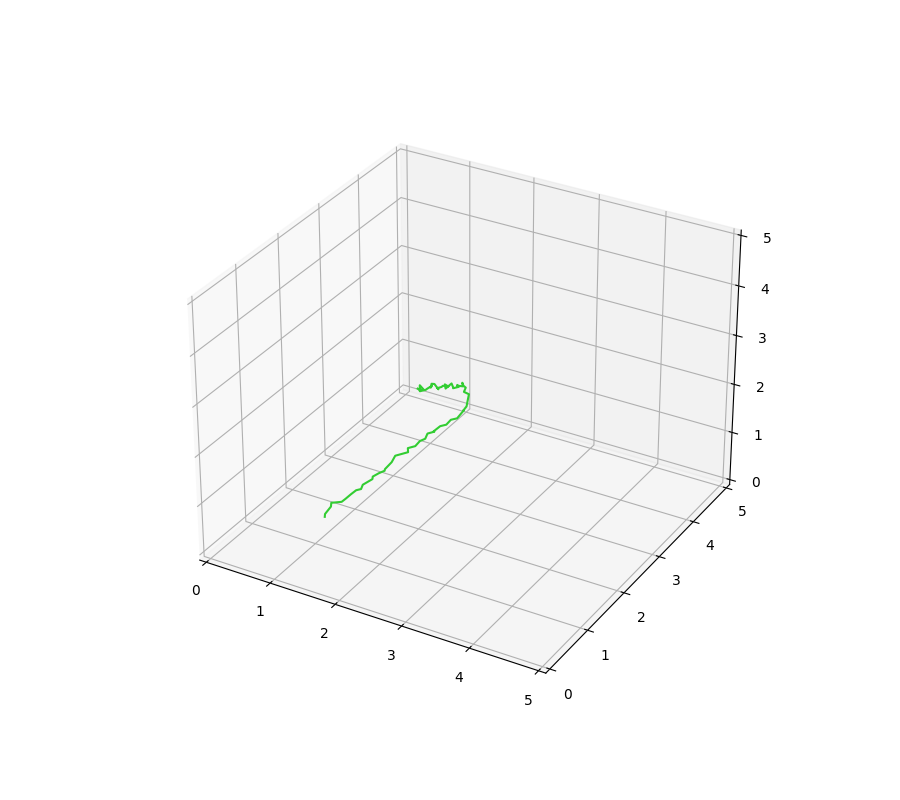

Output()

In [6]:
fig = plt.figure(figsize=(9, 8), dpi=100)
ax = plt.axes(projection='3d')

ui = widgets.VBox([eps_ia, 
                   minpts_ia, 
                   targets_ia,
                   plt_fdets_ia])
out = interactive_output(update, {'eps': eps_ia, 'minpts': minpts_ia, 'targ_select': targets_ia, 'plt_fdets': plt_fdets_ia})
display(ui, out)